[Gantt with plotly](https://plotly.com/python/gantt/)
* for loop on author, create additional dict
* if author has fixed dates, one entry (param "sure")
* if author has uncertain dates, one entry for uncertain birth span (param "uncertain"), one entry for sure life (param "sure"), one entry for uncertain death span (param "uncertain")
* param "sure" = full bar - param "uncertain" = stripes
* color according to total number of mentions?

In [33]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
import re

In [28]:
author_orig = pd.read_csv(
    "output/extraction_20220924_1926/all_classic_occurrences_20220924_1926.csv",
    skip_blank_lines=False,
    infer_datetime_format = True,
    na_filter=False
)
print(list(author_orig))
        
author_orig.head(10)

['ID', 'Auteur', 'BnF', 'IdRef', 'Naissance (min)', 'Naissance (max)', 'Mort (min)', 'Mort (max)', 'N°', 'Témoin', 'Contexte G', 'Mention', 'Contexte D', 'Paragraphe', 'Partie', 'Chapitre', 'Section']


,ID,Auteur,BnF,IdRef,Naissance (min),Naissance (max),Mort (min),Mort (max),N°,Témoin,Contexte G,Mention,Contexte D,Paragraphe,Partie,Chapitre,Section
0,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,1,basnage,"L ’ échange, suivant le sentiment d ’",Aristote,", Polit. l. 1. c. 9. n ’ est point une negocia...","L ’ échange, suivant le sentiment d ’ Aristote...",coutume,TITRE DE JURISDICTION.,III.
1,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,2,basnage,La Coûtume qui punit indistinctement ceux qui ...,Aristote,’ étoit plus conforme au Christianisme : Il es...,La Coûtume qui punit indistinctement ceux qui ...,coutume,DES FIEFS ET DROITS FEODAUX,CXLIX.
2,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,3,basnage,Pour la mere et l ’ enfant on disoit que les J...,Arist,. de Nat. anim. l. 7. c. 7. On apprend d ’ Aul...,Pour la mere et l ’ enfant on disoit que les J...,coutume,DE SUCCESSIONS EN PROPRE,CCXXXV. Temps et acte de l ’ adition d ’ hered...
3,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,4,basnage,Pour la mere et l ’ enfant on disoit que les J...,Aristote,remarque au lieu préallégué que diverses sorte...,Pour la mere et l ’ enfant on disoit que les J...,coutume,DE SUCCESSIONS EN PROPRE,CCXXXV. Temps et acte de l ’ adition d ’ hered...
4,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,5,basnage,Nonobstant ces autoritez la disposition de l ’...,Aristote,", Politic. l. 1. c. ult. et hic. l. 5. c. 10. ...",Nonobstant ces autoritez la disposition de l ’...,coutume,DU DOUAIRE.,CCCLXIX. Femme quand a doüaire sur les biens d...
5,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,6,basnage,,Aristote,avoit apparemment emprunté cette morale des Lo...,Aristote avoit apparemment emprunté cette mora...,coutume,DU DOUAIRE.,CCCLXIX. Femme quand a doüaire sur les biens d...
6,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,7,basnage,Nos Ordonnances ont marqué le temps auquel ceu...,Aristote,ont reculé fort loin le temps propre au mariag...,Nos Ordonnances ont marqué le temps auquel ceu...,coutume,DU DOUAIRE.,CCCLXIX. Femme quand a doüaire sur les biens d...
7,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,8,basnage,Nos Ordonnances ont marqué le temps auquel ceu...,Arist,. lib. 7. c. 17. politic. Le premier ne permet...,Nos Ordonnances ont marqué le temps auquel ceu...,coutume,DU DOUAIRE.,CCCLXIX. Femme quand a doüaire sur les biens d...
8,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,9,basnage,Que si la convention n ’ exprime point la port...,Aristo,. eod.,Que si la convention n ’ exprime point la port...,coutume,DU DOUAIRE.,CCCLXXXIX. Femme n ’ a communauté avec le mary.
9,aristote,Apulée (0125?-0180?),http://data.bnf.fr/ark:/12148/cb125686918,http://www.idref.fr/034995145/id,-0384-01-01,-0384-01-01,-0322-01-01,-0322-01-01,10,basnage,Ce n ’ étoit pas seulement dans Lacedemone qu ...,Aristote,", l. 2. c. 5. et 7. et l. 6. c. 4. Politic. re...",Ce n ’ étoit pas seulement dans Lacedemone qu ...,coutume,DU DOUAIRE.,CCCCVIII. Remplacement du propre quand est rep...


In [29]:
# Get location of mentions and add count of mention in each.
no_quote = author_orig[['ID', 'Auteur', 'Naissance (min)', 'Naissance (max)', 'Mort (min)', 'Mort (max)', 'Témoin', 'Partie', 'Chapitre', 'Section']]
no_quote_new = no_quote.groupby(no_quote.columns.tolist(), as_index=False).size()
print(list(no_quote_new))

['ID', 'Auteur', 'Naissance (min)', 'Naissance (max)', 'Mort (min)', 'Mort (max)', 'Témoin', 'Partie', 'Chapitre', 'Section', 'size']


In [30]:
no_quote_new['Localisation'] = no_quote_new['Partie'].map(str) + " > " + no_quote_new['Chapitre'].map(str) + " > " + no_quote_new['Section'].map(str)
del no_quote_new['Partie']
del no_quote_new['Chapitre']
del no_quote_new['Section']
print(no_quote_new.head(10))

no_quote_new['Thème'] = ''

          ID                                       Auteur Naissance (min)  \
0   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
1   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
2   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
3   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
4   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
5     ammian               Ammien Marcellin (0330?-0400?)      0330-01-01   
6     ammian               Ammien Marcellin (0330?-0400?)      0330-01-01   
7      anast  Anastase I (0431?-0518 ; empereur d'Orient)      0431-01-01   
8      anast  Anastase I (0431?-0518 ; empereur d'Orient)      0431-01-01   
9  antipater                                                  -0099-01-01   

  Naissance (max)  Mort (min)  Mort (max)   Témoin  size  \
0      0340-01-01  0397-01-01  0397-01-01  basnage     4   
1      0340-01-01  0397-01-01  0

In [32]:
for idx, row in no_quote_new.iterrows():
    
    if row['Auteur'] == '':
        no_quote_new.at[idx, 'Auteur'] = row['ID']
    
    lowitem = row['Localisation'].lower()
    
    if re.search(r"do[vuü]aire", lowitem):
        no_quote_new.at[idx, 'Thème'] = "douaire"
    elif re.search(r"(testamen)|(patrimoine)|(s[vu]ccession)|(donation)|(inventaire)|(servit[vu]de)|(heritage)", lowitem):
        no_quote_new.at[idx, 'Thème'] = "successions"
    elif "<front>" in lowitem:
        no_quote_new.at[idx, 'Thème'] = "matière liminaire"
    elif re.search(r"(fief)|(personne)|([ée]glise)|(seigneur)|(ro[iy])", lowitem):
        no_quote_new.at[idx, 'Thème'] = "société"
    elif re.search(r"(crime)|(garde)|(q[vu]erelle)|(execution)|(d[ée]cret)|(haro)|([jil]ustice)|([jil]uge)|([jil][uv]ris?diction)|(st[iy]l+e)", lowitem):
        no_quote_new.at[idx, 'Thème'] = "justice"
    elif "mariage" in lowitem:
        no_quote_new.at[idx, 'Thème'] = "mariage"
    elif re.search(r"(meuble)|(varech)|(banon)|(fores?t)|(prescription)|(bourse)|(namp)", lowitem):
        no_quote_new.at[idx, 'Thème'] = "propriété"
    else:
        print(item)

print(no_quote_new.head(10))
        
no_quote_new.to_csv("output/no_quote_20220927.csv")

          ID                                       Auteur Naissance (min)  \
0   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
1   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
2   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
3   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
4   ambroise                Ambroise (0340?-0397 ; saint)      0340-01-01   
5     ammian               Ammien Marcellin (0330?-0400?)      0330-01-01   
6     ammian               Ammien Marcellin (0330?-0400?)      0330-01-01   
7      anast  Anastase I (0431?-0518 ; empereur d'Orient)      0431-01-01   
8      anast  Anastase I (0431?-0518 ; empereur d'Orient)      0431-01-01   
9  antipater                                    antipater     -0099-01-01   

  Naissance (max)  Mort (min)  Mort (max)   Témoin  size  \
0      0340-01-01  0397-01-01  0397-01-01  basnage     4   
1      0340-01-01  0397-01-01  0

In [ ]:
# Get mentionning author and add cound of mention for each.
by_custAuthor = author_orig[['ID', 'Auteur', 'Naissance (min)', 'Naissance (max)', 'Mort (min)', 'Mort (max)', 'Témoin']]
by_custAuthor_new = by_custAuthor.groupby(by_custAuthor.columns.tolist(), as_index=False).size()

In [45]:
# Get mentionned authors and add count of mentions for each.
authors = author_orig[['ID', 'Auteur', 'Naissance (min)', 'Naissance (max)', 'Mort (min)', 'Mort (max)']]
authors_new = authors.groupby(authors.columns.tolist(), as_index=False).size().drop_duplicates()

authors = []

for idx, row in no_quote_new.iterrows():
    
    if row['Auteur'] == '':
        authorName = row['ID']
    else:
        authorName = row['Auteur']
     
    if row['Naissance (min)'] == row['Naissance (max)'] and row['Mort (min)'] == row['Mort (max)']:
        vie = {
            'author' : authorName,
            'information' : 'Vie',
            'start' : row['Naissance (max)'],
            'finish' : row['Mort (min)']
        }
        authors.append(vie)
        del vie
    
    elif row['Mort (min)'] == row['Mort (max)']:
        vie = {
            'author' : authorName,
            'information' : 'Vie',
            'start' : row['Naissance (max)'],
            'finish' : row['Mort (min)']
        }
        naissance = {
            'author' : authorName,
            'information' : 'Naissance (période)',
            'start' : row['Naissance (min)'],
            'finish' : row['Naissance (max)']
        }
        authors.append(vie)
        authors.append(naissance)
        del vie
        del naissance
    
    else:
        vie = {
            'author' : authorName,
            'information' : 'Vie',
            'start' : row['Naissance (max)'],
            'finish' : row['Mort (min)']
        }
        naissance = {
            'author' : authorName,
            'information' : 'Naissance (période)',
            'start' : row['Naissance (min)'],
            'finish' : row['Naissance (max)']
        }
        mort = {
            'author' : authorName,
            'information' : 'Mort (période)',
            'start' : row['Mort (min)'],
            'finish' : row['Mort (max)']
        }
        authors.append(vie)
        authors.append(naissance)
        authors.append(mort)
        del vie
        del naissance
        del mort
        


with open('dataviz/2022-09-27/authors_for_gantt_chart.csv', 'w') as csvfile:
    
    writer = csv.DictWriter(csvfile, fieldnames = ['author', 'information', 'start', 'finish'])
    writer.writeheader()
    writer.writerows(authors)
    
authors_csv = pd.read_csv(
    "dataviz/2022-09-27/authors_for_gantt_chart.csv",
    skip_blank_lines=False,
    infer_datetime_format = True,
    na_filter=False
)
authors_out = authors_csv.drop_duplicates(keep = 'first')
authors_out.head(10)

authors_out.to_csv('dataviz/2022-09-27/authors_for_gantt_chart.csv')

<AxesSubplot:>

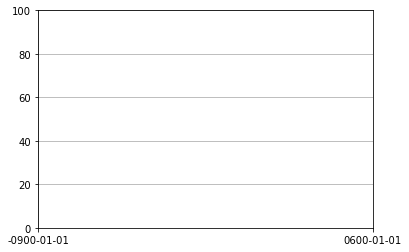

In [17]:
authors_np = authors_new.to_numpy()

# Declaring a figure "gnt"
fig, gnt = plt.subplots()

# Setting X-axis limits
gnt.set_xlim("-0900-01-01", "0600-01-01")

# Setting Y-axis limits
gnt.set_ylim(0, 100)

# Setting graph attribute
gnt.grid(True)



gnt

In [4]:
# Export results

# Get current time
dt = datetime.now()
tmsp = dt.strftime("%Y%m%d_%H%M")


# Construct the path for outputs. 
current_dir = os.getcwd()
new_dir = f"{current_dir}/output/dataviz_{tmsp}"
os.mkdir(new_dir)

no_quote_new.to_csv(f"{new_dir}/no_quote_{tmsp}.csv")
by_custAuthor_new.to_csv(f"{new_dir}/by_custAuthor_{tmsp}.csv")
authors_new.to_csv(f"{new_dir}/authors_{tmsp}.csv")